In [199]:
from pylab import *

import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present, rcond=5e-2), Past)


def train_pinv_diag(past, present):
    return np.diag(np.dot(np.linalg.pinv(present, rcond=5e-2), past))

def ls_train(past, present):
    lsWt = np.linalg.lstsq(present, past)
    return lsWt[0]
    

# HD Algo
def train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):

    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    
def graphwstd(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):
    """
    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')
    """
    
    fig = plt.figure(figsize=(4,3))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend)

    plt.xlabel('Number Training Examples')
    plt.ylabel('Feature Similarity')
    plt.title(title)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [193]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)

data_size = len(reg_pres)
reg_pres, reg_past, reg_freq = reg_pres[:data_size], reg_past[:data_size], reg_freq[:data_size]
irreg_pres, irreg_past, irreg_freq = irreg_pres[:data_size], irreg_past[:data_size], irreg_freq[:data_size]

regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

#train_cutoff = 1700
#train_cutoff = 70

train_frac = 0.7
reg_cutoff = int(len(regular) * train_frac)
irreg_cutoff = int(len(irregular) * train_frac)

train_reg = regular[0:reg_cutoff]
train_irreg = irregular[0:irreg_cutoff]


test_reg = regular[reg_cutoff:]
test_irreg = irregular[irreg_cutoff:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [194]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

In [195]:
print trainpres1.shape, 



(1845, 1000)


True


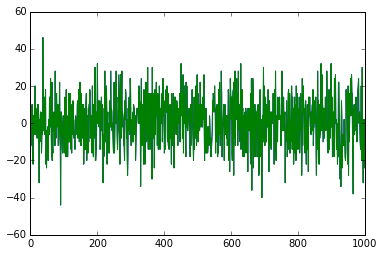

In [30]:
outer = np.dot(trainpres1.T, trainpast2)

outer_sum = np.zeros_like(outer)

for i in range(trainpres1.shape[0]):
    outer_sum += np.outer(trainpres1[i], trainpast2[i])
    
plot(outer[:, 0])
plot(outer_sum[:, 0])

print np.allclose(outer, outer_sum)

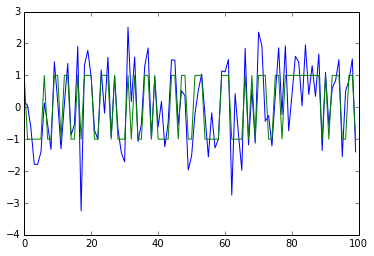

In [36]:
i = 5
tp2 = np.dot(outer.T, trainpres1[i])

plot(tp2[:100]/1000)
plot(trainpast2[i, :100])


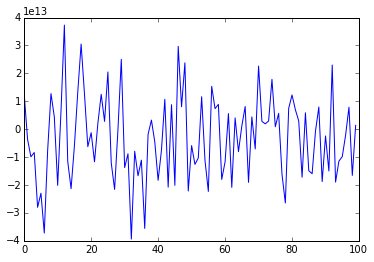

In [41]:
outer_x = np.dot(trainpres1.T, trainpres1)

outer_x_inv = np.linalg.inv(outer_x)

plot(outer_x_inv[:100, 0])

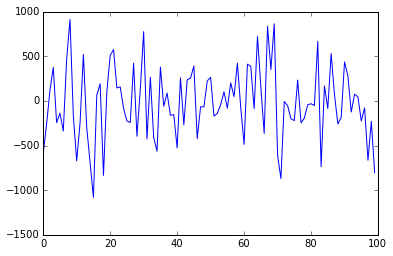

In [43]:
regW = np.dot(outer_x_inv, outer)

plot(regW[:100, 0])

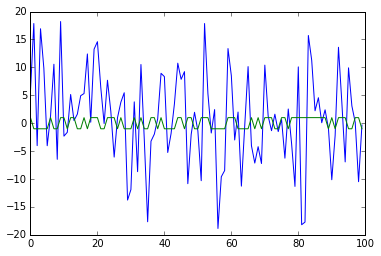

In [45]:
i = 5
rtp2 = np.dot(regW, trainpres1[i])

plot(rtp2[:100]/1000)
plot(trainpast2[i, :100])

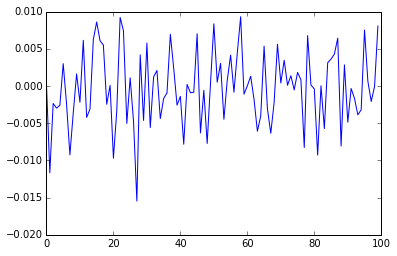

In [81]:
k = 20

piW = closed_train(trainpast2[:k], trainpres1[:k])

plot(piW[:100, 0])

1000.0


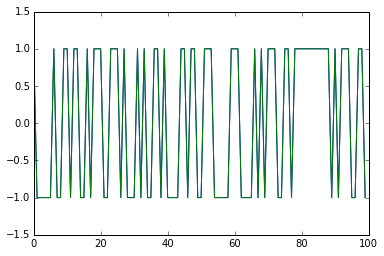

In [82]:
i = 5
ptp2 = np.dot(piW.T, trainpres1[i])

plot(ptp2[:100])
plot(trainpast2[i, :100])

print np.dot(ptp2, trainpast2[i])

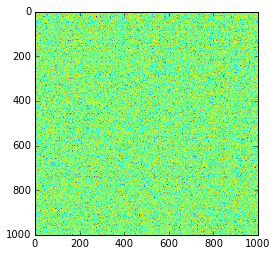

In [83]:
imshow(piW)

In [168]:
k = 900

lsWt = np.linalg.lstsq(trainpres1[:k], trainpast2[:k])

In [192]:
testpres1.shape

(528, 1000)

In [170]:
lsW = lsWt[0]

1000.0


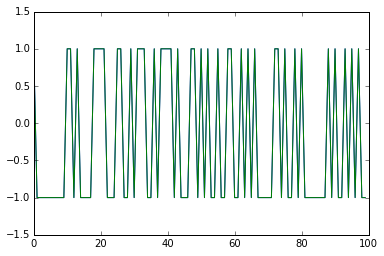

In [171]:
i = 5
lsp2 = np.dot(trainpres1[i], lsW)

plot(lsp2[:100])
plot(trainpast2[i, :100])

print np.dot(lsp2, trainpast2[i])

15.842495118


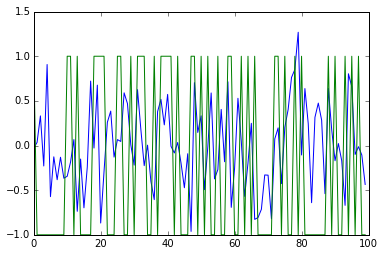

In [164]:
i = 5
pi_bind = diag(piW)

pi_bind_p2 = pi_bind * trainpres1[i]

plot(pi_bind_p2[0:100]*100)
plot(trainpast2[i, 0:100])

print np.dot(pi_bind_p2*100, trainpast2[i])

38.0


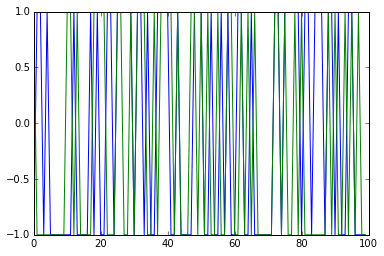

In [165]:
pi_bind_p2_cl = 2*(pi_bind_p2 > 0) - 1

plot(pi_bind_p2_cl[0:100])
plot(trainpast2[i, 0:100])

print np.dot(pi_bind_p2_cl, trainpast2[i])

-195.6055548


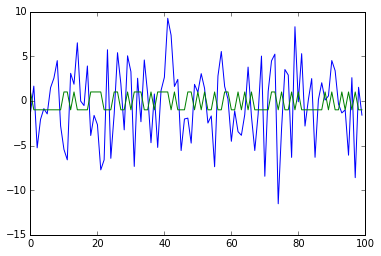

In [166]:
i = 5
ls_bind = diag(lsW)

ls_bind_p2 = ls_bind * trainpres1[i]

plot(ls_bind_p2[0:100]*100)
plot(trainpast2[i, 0:100])

print np.dot(ls_bind_p2*100, trainpast2[i])

-36.0


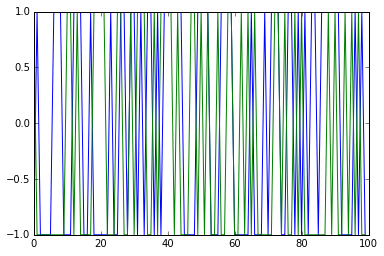

In [167]:
ls_bind_p2_cl = 2*(ls_bind_p2 > 0) - 1

plot(ls_bind_p2_cl[0:100])
plot(trainpast2[i, 0:100])

print np.dot(ls_bind_p2_cl, trainpast2[i])

In [93]:
bind_mem = np.zeros(N)

for i in range(k):
    bind_mem += trainpres1[i] * trainpres2[i]
    

708.0


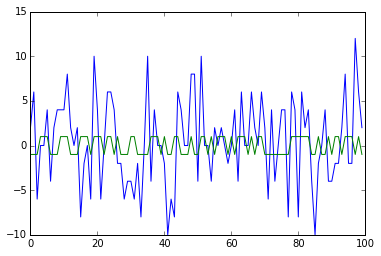

In [94]:

bind_p2 = bind_mem * trainpres1[i]

plot(bind_p2[0:100])
plot(trainpast2[i, 0:100])

print np.dot(bind_p2, trainpast2[i])

100.0


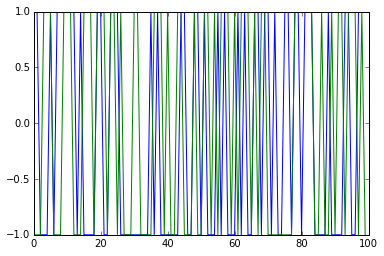

In [95]:
bind_p2_cl = 2*(bind_p2 > 0) - 1

plot(bind_p2_cl[0:100])
plot(trainpast2[i, 0:100])

print np.dot(bind_p2_cl, trainpast2[i])

In [ ]:
function X = pinv(A,tol)
%PINV   Pseudoinverse.
%   X = PINV(A) produces a matrix X of the same dimensions
%   as A' so that A*X*A = A, X*A*X = X and A*X and X*A
%   are Hermitian. The computation is based on SVD(A) and any
%   singular values less than a tolerance are treated as zero.
%   The default tolerance is MAX(SIZE(A)) * NORM(A) * EPS(class(A)).
%
%   PINV(A,TOL) uses the tolerance TOL instead of the default.
%
%   Class support for input A: 
%      float: double, single
%
%   See also RANK.
 
%   Copyright 1984-2013 The MathWorks, Inc. 

[U,S,V] = svd(A,'econ');
s = diag(S);
if nargin < 2 
    tol = max(size(A)) * eps(norm(s,inf));
end
r1 = sum(s > tol)+1;
V(:,r1:end) = [];
U(:,r1:end) = [];
s(r1:end) = [];
s = 1./s(:);
X = bsxfun(@times,V,s.')*U';


In [196]:
tst = time.time()

ntrain_x = np.arange(5, trainpres1.shape[0], 20)

train_hist = np.nan* np.zeros((ntrain_x.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((ntrain_x.shape[0], testpast2.shape[0]))

for i, ntrain in enumerate(ntrain_x): # range(trainpres1.shape[0]):#trainpres1.shape[0]):
    k = ntrain+1
    print k,
    W = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    train_hist[i, :k] = sim(train_pred, trainpast2[:k])
    test_hist[i, :] = sim(test_pred, testpast2)
    
print 'Elapsed:', time.time() - tst


6 26 46 66 86 106 126 146 166 186 206 226 246 266 286 306 326 346 366 386 406 426 446 466 486 506 526 546 566 586 606 626 646 666 686 706 726 746 766 786 806 826 846 866 886 906 926 946 966 986 1006 1026 1046 1066 1086 1106 1126 1146 1166 1186 1206 1226 1246 1266 1286 1306 1326 1346 1366 1386 1406 1426 1446 1466 1486 1506 1526 1546 1566 1586 1606 1626 1646 1666 1686 1706 1726 1746 1766 1786 1806 1826 Elapsed: 75.173429966


figures/trigram_dict-pinv-N=1000-W=1845-170414


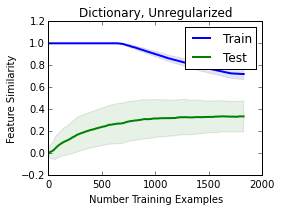

In [198]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

#plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper right')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Dictionary, Unregularized')

#xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/trigram_dict-pinv-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [200]:
tst = time.time()

ntrain_x = np.arange(5, trainpres1.shape[0], 30)


train_hist = np.nan* np.zeros((ntrain_x.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((ntrain_x.shape[0], testpast2.shape[0]))


for i, ntrain in enumerate(ntrain_x): # range(trainpres1.shape[0]):#trainpres1.shape[0]):
    k = ntrain+1
    print k,
    W = train_pinv_diag(trainpast2[:k], trainpres1[:k])
    train_pred = np.multiply(trainpres1[:k], W)
    test_pred = np.multiply(testpres1, W)

    train_hist[i, :k] = sim(train_pred, trainpast2[:k])
    test_hist[i, :] = sim(test_pred, testpast2)
    
    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
print 'Elapsed:', time.time() - tst


6 36 66 96 126 156 186 216 246 276 306 336 366 396 426 456 486 516 546 576 606 636 666 696 726 756 786 816 846 876 906 936 966 996 1026 1056 1086 1116 1146 1176 1206 1236 1266 1296 1326 1356 1386 1416 1446 1476 1506 1536 1566 1596 1626 1656 1686 1716 1746 1776 1806 1836 Elapsed: 51.1419878006


figures/trigram_dict-pinv_diag-N=1000-W=1845-170414


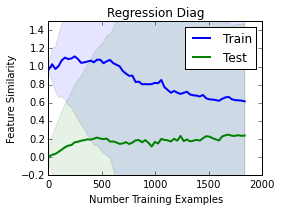

In [202]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)
test_mean = test_hist.mean(axis=1)
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1) #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1) #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

#plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper right')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Regression Diag')

#xlim([0, 1700])
ylim([-0.2, 1.5])
plt.tight_layout()

fname =  ('figures/trigram_dict-pinv_diag-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [174]:
tst = time.time()

ntrain_x = np.arange(5, trainpres1.shape[0], 20)

train_hist = np.nan* np.zeros((ntrain_x.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((ntrain_x.shape[0], testpast2.shape[0]))

for i, ntrain in enumerate(ntrain_x): # range(trainpres1.shape[0]):#trainpres1.shape[0]):
    k = ntrain+1
    print k,
    W = ls_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    train_hist[i, :k] = sim(train_pred, trainpast2[:k])
    test_hist[i, :] = sim(test_pred, testpast2)
    
print 'Elapsed:', time.time() - tst


6 26 46 66 86 106 126 146 166 186 206 226 246 266 286 306 326 346 366 386 406 426 446 466 486 506 526 546 566 586 606 626 646 666 686 706 726 746 766 786 806 826 846 866 886 906 926 946 966 986 1006 1026 1046 1066 1086 1106 1126 1146 1166 1186 1206 1226 1246 1266 1286 1306 1326 1346 1366 1386 1406 1426 1446 1466 1486 1506 1526 1546 1566 1586 1606 1626 1646 1666 1686 1706 1726 1746 1766 1786 1806 1826 1846 1866 1886 Elapsed: 174.87428093


figures/trigram_dict-ls_train-N=1000-W=1889-170414


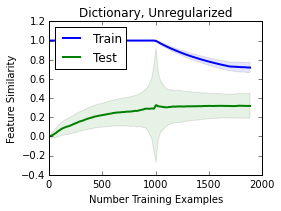

In [175]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

#plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper left')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Dictionary, Unregularized')

#xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/trigram_dict-ls_train-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## xxxxxxxxxxxxxxxxxxxxxxx

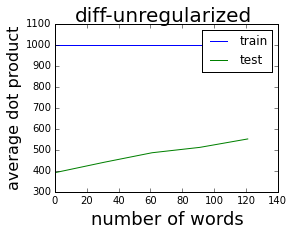

figures/diff_unregularized_trigam_regression-N=1000-W=140-170412


In [5]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 30)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
graph(x,y1,y2,title='diff-unregularized',legend='upper right')

fname =  ('figures/diff_unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

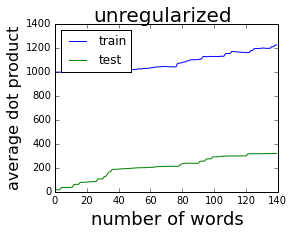

figures/unregularized_outer_trigam_dict-N=1000-W=140-170412


In [6]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()

    W = train(W, trainpast2[k], trainpres1[k])

graph(x,y1/N,y2/N,"unregularized", legend="upper left")

fname =  ('figures/unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

In [7]:
def reg_train(W, Past, Present):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

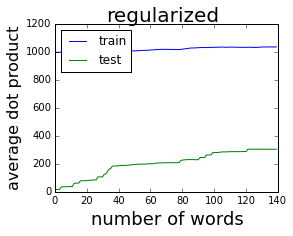

figures/regularized_outer_trigam_dict-N=1000-W=140-170412


In [8]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T).T
    test_pred = np.dot(W, testpres1.T).T
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k, :]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = reg_train(W, trainpast2[k], trainpres1[k])
    

graph(x,y1,y2,title='regularized', legend='upper left')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

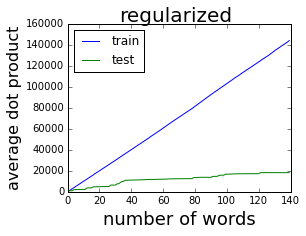

figures/regularized_outer_trigam_dict-N=1000-W=140-170412


In [9]:
# why would changing the order of the transposing change the results?
# which cell is correct? cell 56 or cell 57?
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T)
    test_pred = np.dot(W, testpres1.T)
    
    y1[i] = sim(train_pred, trainpast2[:k, :].T).mean()
    y2[i] = sim(test_pred, testpast2.T).mean()
    
    W = reg_train(W, trainpast2[k], trainpres1[k])

graph(x,y1,y2,title='regularized', legend='upper left')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

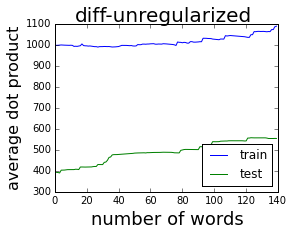

figures/diff_unregularized_outer_trigam_dict-N=1000-W=140-170412


In [10]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    #train_pred = np.dot(W, trainpres1[:k, :].T).T + trainpres2[:k, :]*N
    #test_pred = np.dot(W, testpres1.T).T + (testpres2*N)
    
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-unregularized', legend='lower right')

fname =  ('figures/diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [11]:
def reg_train_diff(W, past2, present1, present2):
    W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)
    return W

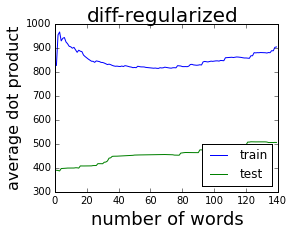

figures/diff_regularized_outer_trigam_dict-N=1000-W=140-170412


In [12]:
W = np.zeros((N,N))
W = reg_train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]

    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    
    #print (train_pred.shape, test_pred.shape)
    y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    W = reg_train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,title='diff-regularized', legend='lower right')

fname =  ('figures/diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)